<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/baseflow-notebooks/blob/main/baseflow_single_station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This notebook serves as an example to demonstrate the usage of the separation functions at a single station. It provides a step-by-step guide on how to apply these functions effectively, covering everything from data acquisition to visualization.***

***We offer two methods for obtaining data for a single station: you can either use the USGS API to directly fetch data, or upload your local dataset.***

***In this notebook, we walk through the entire process, including data preparation, the application of separation functions, and the visualization of results. This example will help users understand how to efficiently implement these functions in their own projects.***

# Install baseflow package from github

In [1]:
!pip install git+https://github.com/BYU-Hydroinformatics/baseflow.git

  Cloning https://github.com/BYU-Hydroinformatics/baseflow.git to /tmp/pip-req-build-11slgjer
  Running command git clone --filter=blob:none --quiet https://github.com/BYU-Hydroinformatics/baseflow.git /tmp/pip-req-build-11slgjer
  Resolved https://github.com/BYU-Hydroinformatics/baseflow.git to commit 50a60ee97f9132f06a30b454ab0d8c5eb4dab97d
  Preparing metadata (setup.py) ... done
  Created wheel for baseflow: filename=baseflow-0.0.9-py3-none-any.whl size=101938 sha256=9a1036f53a77c32ce11ea736cfa980372acb5eda131b0156b607f7f85b06d7b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-sy3onlq1/wheels/f4/6d/fe/c937a4db1017b5070652dfe2b4841589a4aca8cff895ae4abe
Successfully built baseflow


# Load necessary packages

In [2]:
import baseflow
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import urllib.parse
import urllib.request
import os
import numpy as np
from numba import njit, prange

# Download flow data from USGS

This part of the code essentially automates the process of fetching streamflow data for a specific station and time period from the USGS website. It prepares the data for further processing and analysis in the subsequent steps of your notebook.

This part includes:

*   Specify Parameters: You define the station_number, start_date, and end_date to customize the data retrieval.

*   Construct URL: The code constructs the URL for the USGS API request by concatenating different sections. Each section contains specific parameters and filters for the data you want.

*   Retrieve Data: The urllib.request.urlopen(link) function sends a request to the constructed URL and retrieves the data from the USGS website.

*   Decode and Split: The retrieved data is decoded from bytes to a string using .decode(), and then split into lines using .split('\n').

*   Extract Station Name: The code iterates through the lines and extracts the station name from the line starting with "# USGS".

### Specify station number and dates

In this section, you need to type the single streamflow station number, start date and end date of the time period.

You can find stations on USGS website: https://dashboard.waterdata.usgs.gov/app/nwd/en/

In [3]:
station_number = '01636500'
start_date = '2000-01-01' # (YYYY-MM-DD)
end_date = '2022-12-31' # (YYYY-MM-DD)
folder = os.getcwd()

### Scrape USGS Website

Run this cell and it will return this link corresponding to your input. Open the link and check the site number, name, date, etc.

In [4]:
section1 = 'https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no='
section2 = '&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd='\
'LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1&group_key='\
'NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date='
section3 = '&end_date='
section4 = '&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection'

link = (section1 + station_number + section2 + start_date + section3 + end_date + section4)
print("Click here to see the generated USGS link: \n",link)

USGS_page = urllib.request.urlopen(link)
downloaded_data = USGS_page.read()
str_data = downloaded_data.decode()
f_str_data = str_data.split('\n')
station_name = ''

for line in range(len(f_str_data)):
    if f_str_data[line].startswith("#    USGS"):
        station_name=f_str_data[line][3:]
print(station_name)


Click here to see the generated USGS link: 
 https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=01636500&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date=2000-01-01&end_date=2022-12-31&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection
  USGS 01636500 SHENANDOAH RIVER AT MILLVILLE, WV


### Format data
As you have got the link to the station, this block can make the information on the page into a DataFrame with date and streamflow.

In [5]:
date_flow = ''

for line in range(len(f_str_data)):
    if f_str_data[line].startswith("USGS"):
        data = f_str_data[line][14:]
        columns = data.split('\t')
        rows = ','.join([columns[0],(columns[1])])
        date_flow += rows + '\n'
date_flow = date_flow.encode()

with open(folder+'/USGS_Data_for_' + station_number  + '.txt', 'wb') as text:
        text.write(date_flow)

filename = folder+'/USGS_Data_for_' + station_number  + '.txt'
columns = ['Date','Discharge (cfs)']
df = pd.read_csv(filename,header=None,names=columns,parse_dates=[0])
df=df.set_index(['Date'])
df['Discharge (cfs)']=pd.to_numeric(df['Discharge (cfs)'], errors='coerce')
df.tail()

,Discharge (cfs)
Date,
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230
2022-12-30,2880
2022-12-31,2630


# Helper fuctions

In this case, we set up a  single_station function to calculate baseflow for a single station using multiple methods. It takes a streamflow time series as input and allows users to specify the basin area, ice conditions, and the desired baseflow estimation method. The function supports a variety of methods, including UKIH, Local, Fixed, Chapman, and more. Additionally, users can choose to return the Kling-Gupta Efficiency (KGE) values for each method, which provide a measure of the performance of the baseflow separation. The output is a DataFrame containing the baseflow time series for each method and optionally, a Series of KGE values.

In [12]:
from baseflow.utils import *
from baseflow.separation import *
from baseflow.estimate import *

In [13]:
def single_station(series, area=None, ice=None, method='all', return_kge=True):
    """
    Calculates baseflow on a single station using multiple methods.

    Args:
        series (pandas.Series): The streamflow time series to separate.
        area (float): The area of the basin in km^2.
        ice (numpy.ndarray): INSERT DESCRIPTION.
        method (callable): The baseflow estimation method to use.
        return_kge (bool): If True, returns the KGE values for each method.

    Returns:
        pandas.DataFrame: The baseflow time series for each method.
        pandas.Series: The KGE values for each method.
    """
    Q, date = clean_streamflow(series)
    method = format_method(method)

    # convert ice_period ([11, 1], [3, 31]) to bool array
    # if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:
    #     ice = exist_ice(date, ice)
    strict = strict_baseflow(Q, ice)
    if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):
        a = recession_coefficient(Q, strict)

    b_LH = lh(Q)
    b = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b[m] = ukih(Q, b_LH)

        if m == 'Local':
            b[m] = local(Q, b_LH)

        if m == 'Fixed':
            b[m] = fixed(Q, area)

        if m == 'Slide':
            b[m] = slide(Q, area)

        if m == 'LH':
            b[m] = b_LH

        if m == 'Chapman':
            b[m] = chapman(Q, a)

        if m == 'CM':
            b[m] = chapman_maxwell(Q, a)

        if m == 'Boughton':
            C = param_calibrate(np.arange(0.0001, 0.1, 0.0001), boughton, Q, b_LH, a)
            b[m] = boughton(Q, a, C)

        if m == 'Furey':
            A = param_calibrate(np.arange(0.01, 10, 0.01), furey, Q, b_LH, a)
            b[m] = furey(Q, a, A)

        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            BFImax = param_calibrate(np.arange(0.001, 1, 0.001), eckhardt, Q, b_LH, a)
            b[m] = eckhardt(Q, a, BFImax)

        if m == 'EWMA':
            e = param_calibrate(np.arange(0.0001, 0.1, 0.0001), ewma, Q, b_LH, 0)
            b[m] = ewma(Q, e)

        if m == 'Willems':
            w = param_calibrate(np.arange(0.001, 1, 0.001), willems, Q, b_LH, a)
            b[m] = willems(Q, a, w)
    if return_kge:
        KGEs = pd.Series(return_kge(b[strict].values, np.repeat(
            Q[strict], len(method)).reshape(-1, len(method))), index=b.columns)
        return b, KGEs
    else:
        return b, None

# Calculate baseflow at a single site
In this example, we use the data from the USGS API as input. You can also upload your own file to the side bar by clicking the 'Files' button.

Firstly, check the content of the DataFrame.

In [8]:
df

,Discharge (cfs)
Date,
2000-01-01,1870
2000-01-02,1840
2000-01-03,1780
2000-01-04,1720
2000-01-05,1700
...,...
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230


In [14]:
df['Discharge (cfs)']

,Discharge (cfs)
Date,
2000-01-01,1870
2000-01-02,1840
2000-01-03,1780
2000-01-04,1720
2000-01-05,1700
...,...
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230


Then plot the data to have a view of this time series.

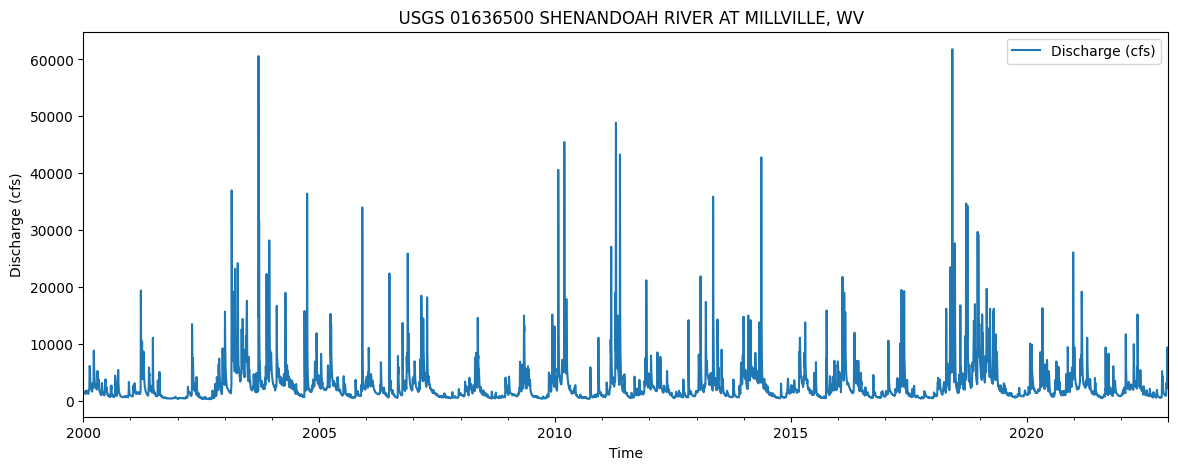

In [15]:
df.plot(figsize=(14,5), title= station_name, xlabel="Time", ylabel="Discharge (cfs)");

Use the single_station helper function to obtain the results. In this example, we demonstrate using the Chapman method.

In [16]:
result = single_station(df['Discharge (cfs)'], method='Chapman', return_kge=False)
print(result)

(                Chapman
Date                   
2000-01-01  1870.000000
2000-01-02  1837.500819
2000-01-03  1780.000000
2000-01-04  1720.000000
2000-01-05  1690.173166
...                 ...
2022-12-27  1203.837498
2022-12-28  1235.514717
2022-12-29  1253.427551
2022-12-30  1262.878087
2022-12-31  1266.830467

[8401 rows x 1 columns], None)


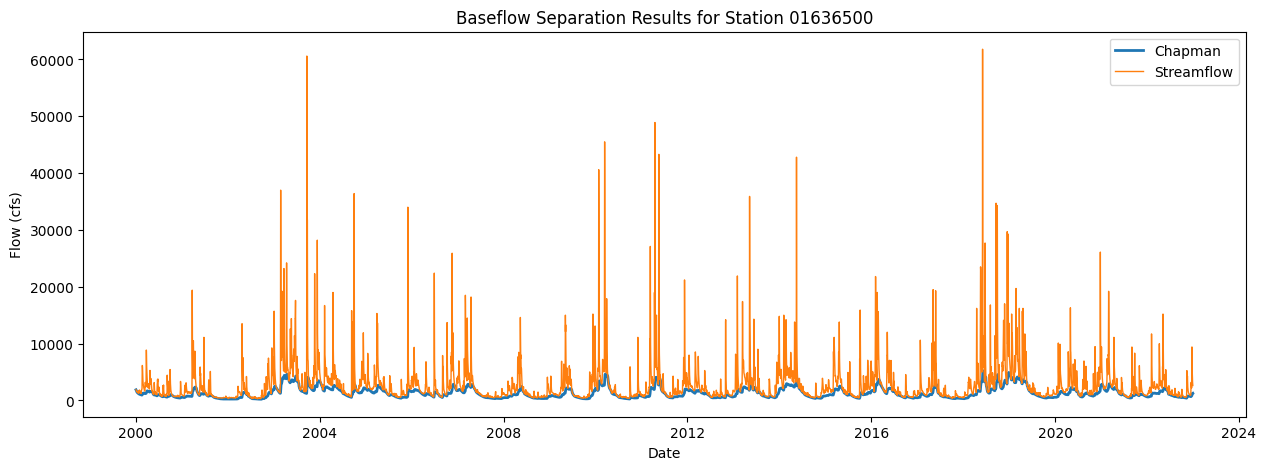

In [18]:
chapman_baseflow = result[0]  # Access the first element of the tuple

# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index, chapman_baseflow, label='Chapman', linewidth=2)  # Use the extracted baseflow
ax.plot(df.index, df['Discharge (cfs)'], label='Streamflow', linewidth=1)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Flow (cfs)')
ax.set_title(f'Baseflow Separation Results for Station {station_number}');

To use multiple baseflow separation methods on the same station, simply provide a list of methods to the single_station function. For example, to use both the Chapman and CM methods:

In [23]:
result2 = single_station(df['Discharge (cfs)'], method=['Chapman','CM'], return_kge=False)
print(result2)

(                Chapman           CM
Date                                
2000-01-01  1870.000000  1870.000000
2000-01-02  1837.500819  1837.522179
2000-01-03  1780.000000  1780.000000
2000-01-04  1720.000000  1720.000000
2000-01-05  1690.173166  1690.257154
...                 ...          ...
2022-12-27  1203.837498  1219.585127
2022-12-28  1235.514717  1242.675657
2022-12-29  1253.427551  1255.404376
2022-12-30  1262.878087  1261.715180
2022-12-31  1266.830467  1263.536838

[8401 rows x 2 columns], None)


This will return a DataFrame containing the baseflow time series for both methods.

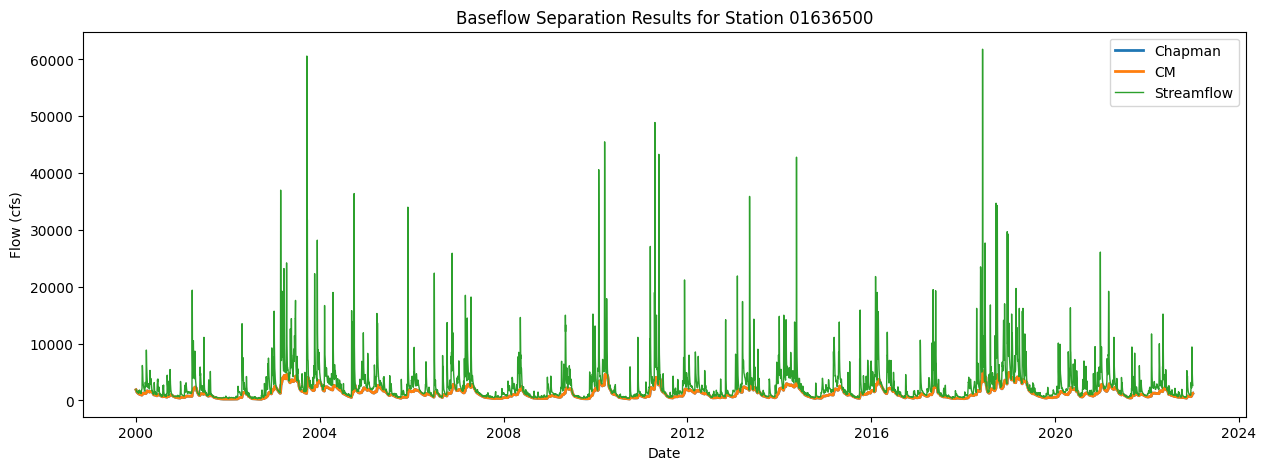

In [24]:
chapman_cm_baseflow = result2[0]  # Access the first element of the tuple

# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index, chapman_cm_baseflow['Chapman'], label='Chapman', linewidth=2)  # Use the extracted baseflow
ax.plot(df.index, chapman_cm_baseflow['CM'], label='CM', linewidth=2)  # Use the extracted baseflow
ax.plot(df.index, df['Discharge (cfs)'], label='Streamflow', linewidth=1)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Flow (cfs)')
ax.set_title(f'Baseflow Separation Results for Station {station_number}');
